## Imports

In [1]:
import numpy as np

from flood_adapt.objects import (
    EventSet
)

## Step 1: Inputs (Event set)

In [2]:
fn_event_set = r"c:\Users\winter_ga\Offline_data\FloodAdapt-WorkingDatabase\Charleston\4_FloodAdapt\Database\charleston_beta_release\input\events\event_set_coastal\event_set_coastal.toml"
event_set = EventSet.load_file(fn_event_set)

# Input for Monte Carlo simulation
seed = 42 # For reproducibility in Monte Carlo simulation
years = 30  # Number of years to simulate
n_seq = 20  # Number of sequences to simulate (# of Monte Carlo simulations)
dt = 1 # Time step in years


## Step 2: Get events and probabilities, eliminate frequencies > 1

In [3]:
probs = []
event_ids = []
for event in event_set.sub_events:
    if event.frequency <= 1./dt:
        probs.append(event.frequency*dt)
        event_ids.append(event.name)

## Step 3: Create ensemble of event sequences
Using Monte Carlo  

In [4]:
def generate_event_sequences(event_probs, years=30, n_seq=1000, seed=None):
    """
    event_probs: sequence of annual occurrence probabilities (len = n_events)
    returns: boolean array shape (n_sims, years, n_events) where True=event occurs that year
    """
    rng = np.random.default_rng(seed)
    p = np.asarray(event_probs, dtype=float)
    draws = rng.random((n_seq, years, p.size))
    return draws < p[np.newaxis, np.newaxis, :]

def occurrences_to_sequences(occ, event_ids=None):
    """
    occ: boolean array from generate_event_sequences
    event_ids: optional list of identifiers for events (len = n_events)
    returns: list of length n_sims; each element is list of length years with lists of event ids occurring that year
    """
    n_sims, years, n_events = occ.shape
    if event_ids is None:
        event_ids = [f"event_{i}" for i in range(n_events)]
    sequences = []
    for s in range(n_sims):
        sim_seq = []
        for y in range(years):
            evs = [event_ids[i] for i in range(n_events) if occ[s, y, i]]
            sim_seq.append(evs)
        sequences.append(sim_seq)
    return sequences

occ = generate_event_sequences(probs, years=years, n_seq=n_seq, seed=seed)
sequences = occurrences_to_sequences(occ, event_ids=event_ids)
# sim_sequences[0][5]  # Example: events occurring in sequence 0 in year 6


## Step 4: Check results
Check whether average occurrence of events in the sequences matches expected value based on frequency of occurrence. 

In [5]:
# Avergae count occurrences per sequence
for event_id,p in zip(event_ids,probs):
    counts_per_seq = [sum(1 for year in seq if event_id in year) for seq in sequences]
    print(f"Average occurrences of {event_id} per simulation: {np.asarray(counts_per_seq).mean()}. Expected: {years*np.asarray(p)}")




Average occurrences of subevent_2 per simulation: 18.0. Expected: 17.63359995
Average occurrences of subevent_3 per simulation: 2.8. Expected: 2.8593053999999998
Average occurrences of subevent_4 per simulation: 0.45. Expected: 0.30151008


## Step 5: Plot sequences

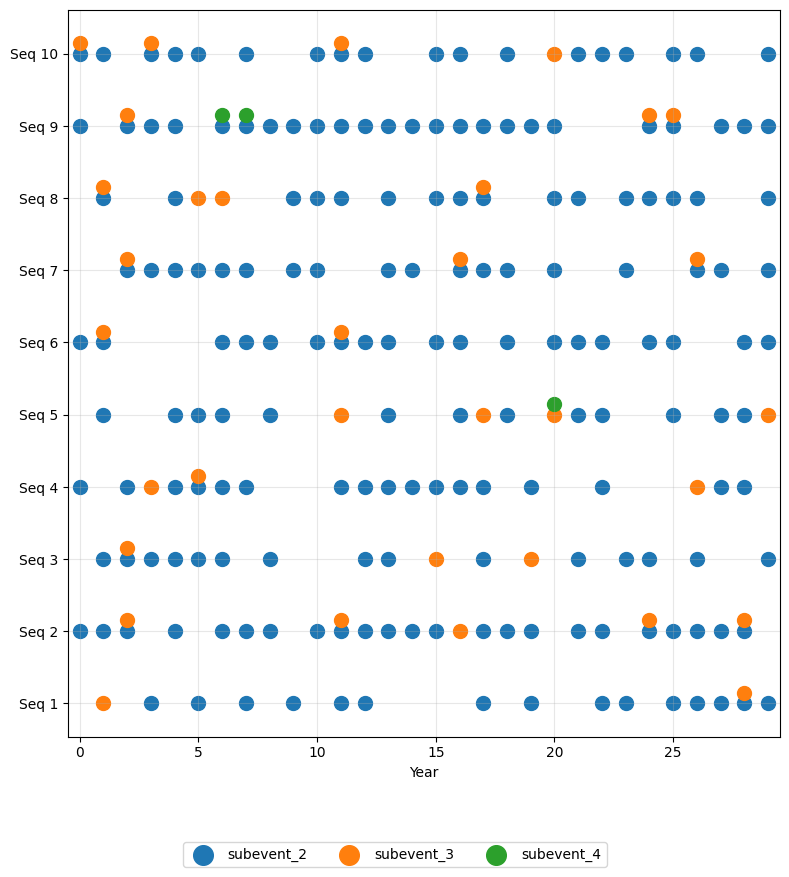

In [29]:
import matplotlib.pyplot as plt

# Create figure with 1 row, 3 columns
fig, axes = plt.subplots(1,1, figsize=(8,8))
seq_max = 10

# Color map for events
colors = {event_id: plt.cm.tab10(i) for i, event_id in enumerate(event_ids)}
yticklabels = []
# Plot first seq_max sequences
for seq_idx in range(min(seq_max, len(sequences))):
    ax = axes#[seq_idx]
    
    # For each year, plot events stacked vertically
    for year_idx, year_events in enumerate(sequences[seq_idx]):
        for marker_offset, event_id in enumerate(sorted(year_events)):
            ax.scatter(year_idx, marker_offset*0.15+seq_idx, 
                      color=colors[event_id], 
                      s=100, 
                      marker='o',
                      label=event_id if year_idx == 0 else "")
    yticklabels.append(f"Seq {seq_idx+1}")
    
ax.set_xlabel('Year')
ax.set_yticks([i for i in range(min(seq_max, len(sequences)))])
ax.set_yticklabels(yticklabels)
# ax.set_title(f'Sequence {seq_idx}')
ax.set_xlim(-0.5, years - 0.5)
# ax.set_ylim(-0.1, 1)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, years, 5))

# Add legend (use unique events)
handles = [plt.scatter([], [], color=colors[e], s=200, marker='o') for e in event_ids]
fig.legend(handles, event_ids, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(event_ids))

plt.tight_layout()
plt.show()

fig.savefig('event_sequences.png', bbox_inches='tight')